<a href="https://colab.research.google.com/github/liuxiaoxuan97/data-science-hw-/blob/master/cs109b_hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [0]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [0]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.3.0-tf
2.2.0-rc2


In [0]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [0]:
# Given code
from google.colab import files
uploaded=files.upload()
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['HW6_data.csv']),encoding="latin1")

data = data.fillna(method="ffill")
data.head(15)

Saving HW6_data.csv to HW6_data.csv


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [0]:
# your code here
uniq_word = data.Word.unique().tolist()
uniq_word = sorted(uniq_word)
uniq_word.append("ENDPAD")
n_words = len(uniq_word)

In [0]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [0]:
# your code here
uniq_tags = data.Tag.unique().tolist()
uniq_tags = sorted(uniq_tags)
uniq_tags.append("PAD")
n_tags = len(uniq_tags)

In [0]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [0]:
# your code here
subset=data[['Word','Tag']]
tp=[tuple(x) for x in subset.values]
data['tp']=tp
grpSent = data.groupby('Sentence #')['tp'].apply(list)
#subset.iloc[0:4,:].values


**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [0]:
# your code here
max_len=max([len(grpSent[i]) for i in range(grpSent.shape[0])])
max_len

104

In [0]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [0]:
# your code here
word2idx = dict((x, i) for i,x in enumerate(uniq_word))
idx2word = dict(map(reversed, word2idx.items()))

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [0]:
# your code here
data['codeword']=data['Word'].map(word2idx)
X=data.groupby('Sentence #')['codeword'].apply(list)
X.head()

Sentence #
Sentence: 1        [15077, 27700, 20969, 24218, 26434, 33389, 968...
Sentence: 10       [8193, 27727, 31033, 33289, 22577, 33464, 2372...
Sentence: 100      [7598, 24039, 13559, 28905, 26765, 24370, 2485...
Sentence: 1000     [15049, 25892, 16915, 16574, 33179, 24592, 323...
Sentence: 10000    [15424, 30227, 20254, 8420, 5852, 30957, 14607...
Name: codeword, dtype: object

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [0]:
# your code here
X=tf.keras.preprocessing.sequence.pad_sequences(
    X, maxlen=max_len, dtype='int32', padding='post',
    value=word2idx['ENDPAD']
)

In [0]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [0]:
# your code here
tag2idx=dict((x,i) for i,x in enumerate(uniq_tags))
idx2tag=dict(map(reversed,tag2idx.items()))
idx2tag

{0: 'B-art',
 1: 'B-eve',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-nat',
 5: 'B-org',
 6: 'B-per',
 7: 'B-tim',
 8: 'I-art',
 9: 'I-eve',
 10: 'I-geo',
 11: 'I-gpe',
 12: 'I-nat',
 13: 'I-org',
 14: 'I-per',
 15: 'I-tim',
 16: 'O',
 17: 'PAD'}

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [0]:
# your code here
y=data['Tag'].map(tag2idx)
data['y']=y
Y=data.groupby('Sentence #')['y'].apply(list)

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [0]:
# your code here
for i in range(len(Y)):
    Y[i].append(17)
Y = tf.keras.preprocessing.sequence.pad_sequences(Y, maxlen=max_len, value=tag2idx["PAD"], padding="post")

In [0]:
Y.shape

(47959, 104)

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [0]:
# your code here
Y=to_categorical(Y)
print(Y.shape,n_tags)
y=Y

(47959, 104, 18) 18


In [0]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [0]:
# your code here
X_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

In [0]:
y_train.shape

(43163, 104, 18)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [0]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [0]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [0]:
#m1=[np.sum(y_train[X_train==i,:],axis=0) for i in idx2word.keys()]

In [0]:
# your code here
baseline = np.array([np.argmax(np.sum(y_train[X_train==i,:],axis=0)) for i in idx2word.keys()])

In [0]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [0]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [0]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [0]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Train model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 25s 21ms/step - loss: 0.3148 - accuracy: 0.9787 - val_loss: 0.0602 - val_accuracy: 0.9858
Epoch 2/10
1214/1214 [==============================] - 24s 20ms/step - loss: 0.0515 - accuracy: 0.9863 - val_loss: 0.0477 - val_accuracy: 0.9868
Epoch 3/10
1214/1214 [==============================] - 25s 21ms/step - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.0448 - val_accuracy: 0.9875
Epoch 4/10
1214/1214 [==============================] - 27s 22ms/step - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.0435 - val_accuracy: 0.9878
Epoch 5/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0415 - accuracy: 0.9881 - val_loss: 0.0428 - val_accuracy: 0.9880
Epoch 6/10
1214/1214 [==============================] - 29s 24ms/step - loss: 0.0407 - accuracy: 0.9883 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 7/10
1214/1214 [==============================] - 26s 22ms/step - loss: 0.0401 - accuracy: 0.9885 - val_loss: 0.0419 -

In [0]:
store_keras_model(model, 'model_FFNN')

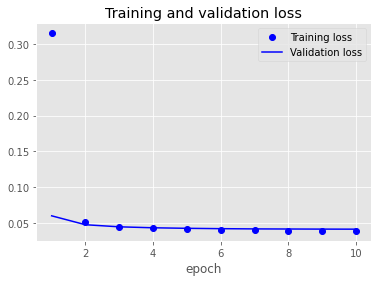

In [0]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*

From Lab, an embedding is a "distributed representation" (e.g., vector) of a particular atomic item (e.g., word token, object, etc). When representing items by embeddings:

each distinct item should be represented by its own unique embedding
the semantic similarity between items should correspond to the similarity between their respective embeddings (i.e., words that are more similar to one another should have embeddings that are more similar to each other).
In general, one can view the embedding process as a linear projection from one vector space to another (e.g., a vector space of unique words being mapped to a world of fixed-length, dense vectors filled with continuous-valued numbers). For NLP, we usually use embeddings to project the one-hot encodings of words  on to a lower-dimensional continuous space so that the input surface is dense and possibly smooth. Thus, one can view this embedding layer process as just a transformation from $R^{inp}$ to $R^{emb}$

We need this layer since many words have different appearance but actually have similar meaning. Embedding layer can create similar vectors to represent these similar words so the model doesn't have to learn new ways to represent similar things.**



**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*

The input is n_words with dim = 35179. The output_dim is 50. So Param # of Embedding layer = 35179*50 = 1758950

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [0]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(model)
hidden_features = truncated_model.predict(x_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9431490240037839


In [0]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

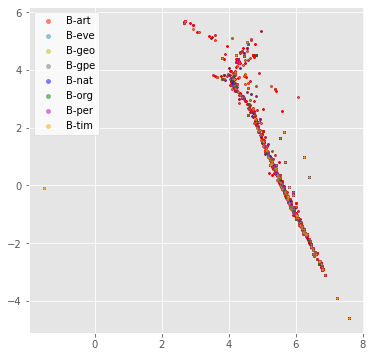

In [0]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [0]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [0]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.943148988376149


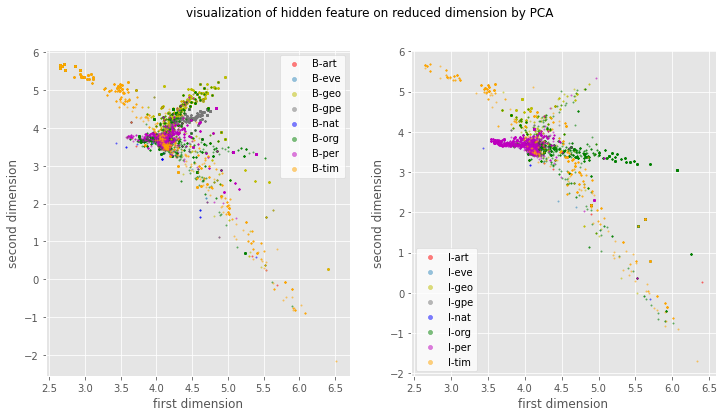

In [0]:
h = get_hidden_output_PCA(model,x_test,y_test,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [0]:
# your code here
drop_rate = .1
dim_embed = 50
batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [0]:
modelRnn=Sequential()
modelRnn.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
modelRnn.add(Dropout(drop_rate))
modelRnn.add(SimpleRNN(dim_embed,return_sequences=True))
modelRnn.add(TimeDistributed(Dense(n_tags, activation="softmax")))
modelRnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
historyRnn = modelRnn.fit(X_train, y_train, epochs=epochs, 
                     validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 50s 41ms/step - loss: 0.1014 - accuracy: 0.9768 - val_loss: 0.0335 - val_accuracy: 0.9903
Epoch 2/10
1214/1214 [==============================] - 50s 41ms/step - loss: 0.0299 - accuracy: 0.9912 - val_loss: 0.0286 - val_accuracy: 0.9916
Epoch 3/10
1214/1214 [==============================] - 53s 44ms/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 0.0274 - val_accuracy: 0.9918
Epoch 4/10
1214/1214 [==============================] - 51s 42ms/step - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0269 - val_accuracy: 0.9919
Epoch 5/10
1214/1214 [==============================] - 50s 41ms/step - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0268 - val_accuracy: 0.9920
Epoch 6/10
1214/1214 [==============================] - 50s 41ms/step - loss: 0.0223 - accuracy: 0.9934 - val_loss: 0.0265 - val_accuracy: 0.9919
Epoch 7/10
1214/1214 [==============================] - 50s 41ms/step - loss: 0.0215 - accuracy: 0.9936 - val_loss: 0.0265 -

In [0]:
# save your mode #
store_keras_model(model, 'model_RNN')

In [0]:
# run this cell to show your results #
print(modelRnn.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 104, 50)           5050      
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           918       
Total params: 1,764,918
Trainable params: 1,764,918
Non-trainable params: 0
_________________________________________________________________
None


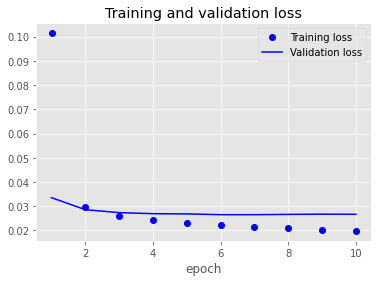

In [0]:
# run this cell to show your results #
plot_training_history(historyRnn)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

In [0]:
# your code here
def create_truncated_model_RNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    model.add(SimpleRNN(dim_embed,return_sequences=True))
    #set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_modelRnn = create_truncated_model_RNN(modelRnn)
hidden_featuresRnn = truncated_modelRnn.predict(x_test)

# flatten data
hidden_featuresRnn=hidden_featuresRnn.reshape(-1,50)
y_test=y_test.reshape(-1,18)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_featuresRnn)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.8533655755084705


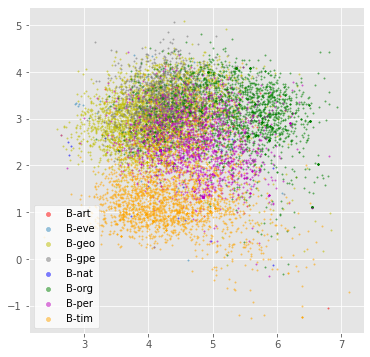

In [0]:
visualize_hidden_features(pca_result)


Variance explained by PCA: 0.9811728171905446


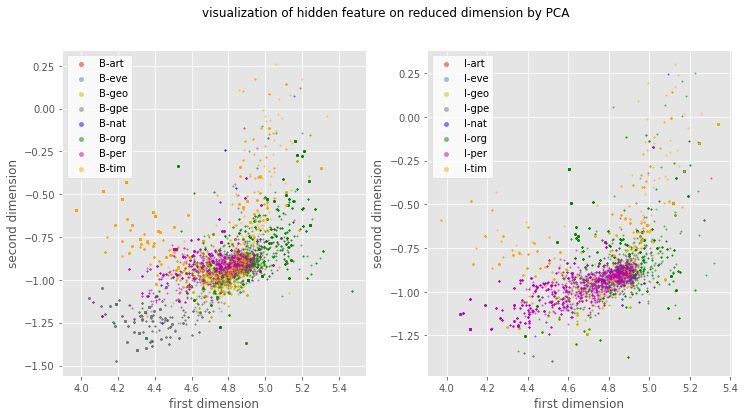

In [0]:
h = get_hidden_output_PCA(modelRnn,x_test,y_test,1,50)
visualize_B_I(h)

**Comment**:
In both plots, there are some color (light green, purple, dark green and orange) clusters. Moreover, for the same color, its clusters in both plots are in the similar location. For instance, using purple (I-per) as an example. Since puple means "per" in both case, its clusters are concentrated in the [4.4-4.8,-1.25--0.754] range.



<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*

GRUs are improved version of standard recurrent neural network. Standard RNN has the vanishing gradient problem. To solve this, GRU uses update gate and reset gate. Basically, updata gate deciveds the amount of past information that should be passed to the output and rest gate decides the amount of past information that should be removed. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information that is irrelevant to the prediction.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [0]:
# your code here
backend.clear_session()
modelGRU=Sequential()
modelGRU.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
modelGRU.add(Dropout(drop_rate))
modelGRU.add(GRU(dim_embed,return_sequences=True))
modelGRU.add(TimeDistributed(Dense(n_tags, activation="softmax")))
modelGRU.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
historyGRU = modelGRU.fit(X_train, y_train, epochs=epochs, 
                     validation_split=validation_split, verbose=verbose)

Epoch 1/10
1214/1214 [==============================] - 92s 76ms/step - loss: 0.1048 - accuracy: 0.9754 - val_loss: 0.0330 - val_accuracy: 0.9903
Epoch 2/10
1214/1214 [==============================] - 93s 77ms/step - loss: 0.0297 - accuracy: 0.9913 - val_loss: 0.0285 - val_accuracy: 0.9916
Epoch 3/10
1214/1214 [==============================] - 97s 80ms/step - loss: 0.0262 - accuracy: 0.9923 - val_loss: 0.0272 - val_accuracy: 0.9919
Epoch 4/10
1214/1214 [==============================] - 94s 77ms/step - loss: 0.0244 - accuracy: 0.9928 - val_loss: 0.0264 - val_accuracy: 0.9920
Epoch 5/10
1214/1214 [==============================] - 91s 75ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0259 - val_accuracy: 0.9922
Epoch 6/10
1214/1214 [==============================] - 95s 78ms/step - loss: 0.0224 - accuracy: 0.9934 - val_loss: 0.0258 - val_accuracy: 0.9921
Epoch 7/10
1214/1214 [==============================] - 93s 76ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.0255 -

In [0]:
# save your model #
store_keras_model(model, 'model_GRU')

In [0]:
# run this cell to show your results #
print(modelGRU.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 50)           15300     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           918       
Total params: 1,775,168
Trainable params: 1,775,168
Non-trainable params: 0
_________________________________________________________________
None


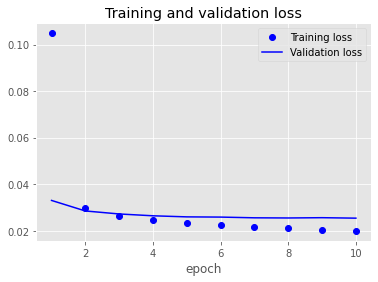

In [0]:
# run this cell to show your results #
plot_training_history(historyGRU)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.9637332395948742


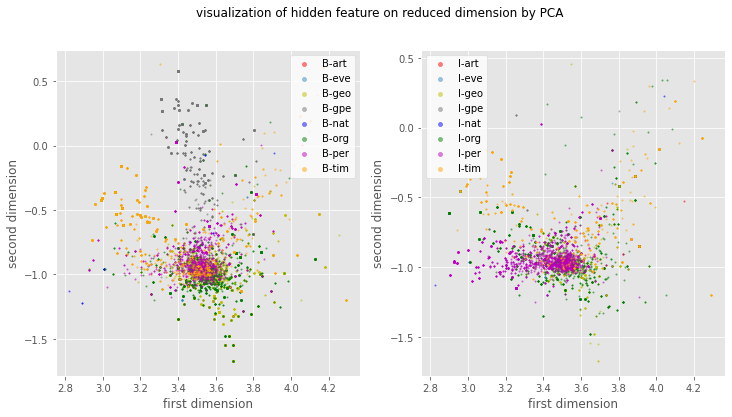

In [0]:
# your code here
h = get_hidden_output_PCA(modelGRU,x_test,y_test,1,50)
visualize_B_I(h)

*your answer here*

In both plots, there are some color (green, purple, orange) clusters overlap on each other. Moreover, for the same color, its clusters in both plots are in the similar location. For instance, green cluster is above purple, the lowest is orange. However, the B-gpe in first plot is on the top while there is no clear I-gpe pattern in the second plot.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



*your answer here*

Bidirectional GRU is just putting two independent GRUs together (while GRU is just one network). The input sequence is fed in normal time order for one network, and in reverse time order for another. The outputs of the two networks are concatenated at each time step. This structure allows the networks to have both backward and forward information about the sequence at every time step.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [0]:
# your code here
#backend.clear_session()

modelBiGRU=Sequential()
modelBiGRU.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
modelBiGRU.add(Dropout(drop_rate))
modelBiGRU.add(Bidirectional(GRU(dim_embed, return_sequences=True)))
modelBiGRU.add(TimeDistributed(Dense(n_tags, activation="softmax")))
modelBiGRU.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

historyBiGRU = modelBiGRU.fit(X_train, y_train, epochs=epochs,validation_split=validation_split, verbose=verbose)


Epoch 1/10
1214/1214 [==============================] - 134s 110ms/step - loss: 0.0837 - accuracy: 0.9801 - val_loss: 0.0281 - val_accuracy: 0.9919
Epoch 2/10
1214/1214 [==============================] - 133s 109ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0239 - val_accuracy: 0.9929
Epoch 3/10
1214/1214 [==============================] - 132s 109ms/step - loss: 0.0212 - accuracy: 0.9938 - val_loss: 0.0227 - val_accuracy: 0.9933
Epoch 4/10
1214/1214 [==============================] - 133s 109ms/step - loss: 0.0193 - accuracy: 0.9943 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 5/10
1214/1214 [==============================] - 132s 109ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.0220 - val_accuracy: 0.9935
Epoch 6/10
1214/1214 [==============================] - 134s 110ms/step - loss: 0.0172 - accuracy: 0.9949 - val_loss: 0.0218 - val_accuracy: 0.9935
Epoch 7/10
1214/1214 [==============================] - 133s 109ms/step - loss: 0.0163 - accuracy: 0.9952 - val_

In [0]:
# save your model #
store_keras_model(model, 'model_BiGRU')

In [0]:
# run this cell to show your results #
print(modelBiGRU.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 100)          30600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,791,368
Trainable params: 1,791,368
Non-trainable params: 0
_________________________________________________________________
None


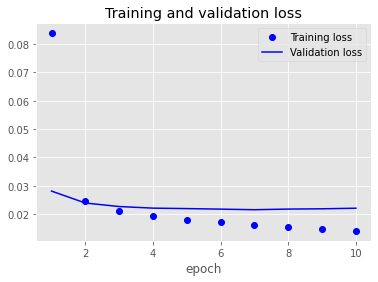

In [0]:
# run this cell to show your results #
plot_training_history(historyBiGRU)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.8192063253651015


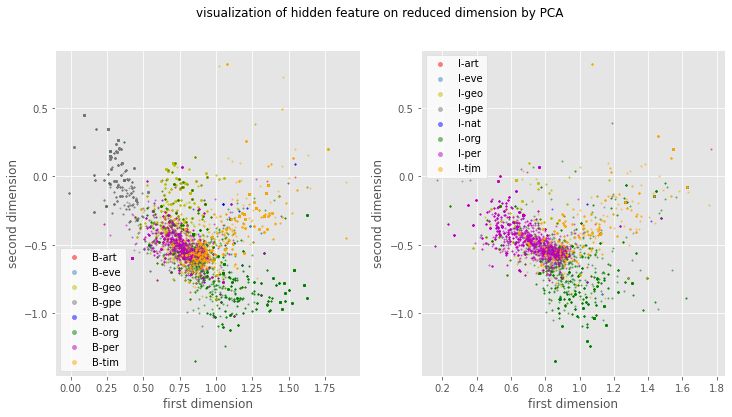

In [0]:
# your code here
h = get_hidden_output_PCA(modelBiGRU,x_test,y_test,1,50)
visualize_B_I(h)

*your answer here*

In this two plots, all the tags are seperated better, there is no obvious cluster patterns. 

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [0]:
# your code here
def get_f1(y_pred, y_true):
    f1_ = f1_score(y_true,y_pred, average=None)
    return(f1_)


def get_accu(y_pred, y_true):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return(cm.diagonal())


model_name_list = ['baseline','model','modelRnn','modelGRU','modelBiGRU']
y_test_reshape = np.argmax(y_test.reshape((-1,18)), axis=1)
f1_list = []
accu_list = []
ypred_list=[]

y_pred0 = baseline[x_test.reshape(-1,1)]
f1_list.append(get_f1(y_pred0, y_test_reshape))
accu_list.append(get_accu(y_pred0, y_test_reshape))
ypred_list.append(y_pred0.reshape((4796,104)))
    
model_predict = model.predict(x_test)
y_pred = np.argmax(model_predict.reshape((-1,18)), axis=1)
f1_list.append(get_f1(y_pred, y_test_reshape))
accu_list.append(get_accu(y_pred, y_test_reshape))
ypred_list.append(y_pred.reshape((4796,104)))

model_predict = modelRnn.predict(x_test)
y_pred = np.argmax(model_predict.reshape((-1,18)), axis=1)
f1_list.append(get_f1(y_pred, y_test_reshape))
accu_list.append(get_accu(y_pred, y_test_reshape))
ypred_list.append(y_pred.reshape((4796,104)))
model_predict = modelGRU.predict(x_test)
y_pred = np.argmax(model_predict.reshape((-1,18)), axis=1)
f1_list.append(get_f1(y_pred, y_test_reshape))
accu_list.append(get_accu(y_pred, y_test_reshape))
ypred_list.append(y_pred.reshape((4796,104)))
model_predict = modelBiGRU.predict(x_test)
y_pred = np.argmax(model_predict.reshape((-1,18)), axis=1)
f1_list.append(get_f1(y_pred, y_test_reshape))
accu_list.append(get_accu(y_pred, y_test_reshape))
ypred_list.append(y_pred.reshape((4796,104)))
    
f1_array = np.asarray(f1_list)
ypred_arr = np.stack(ypred_list)

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

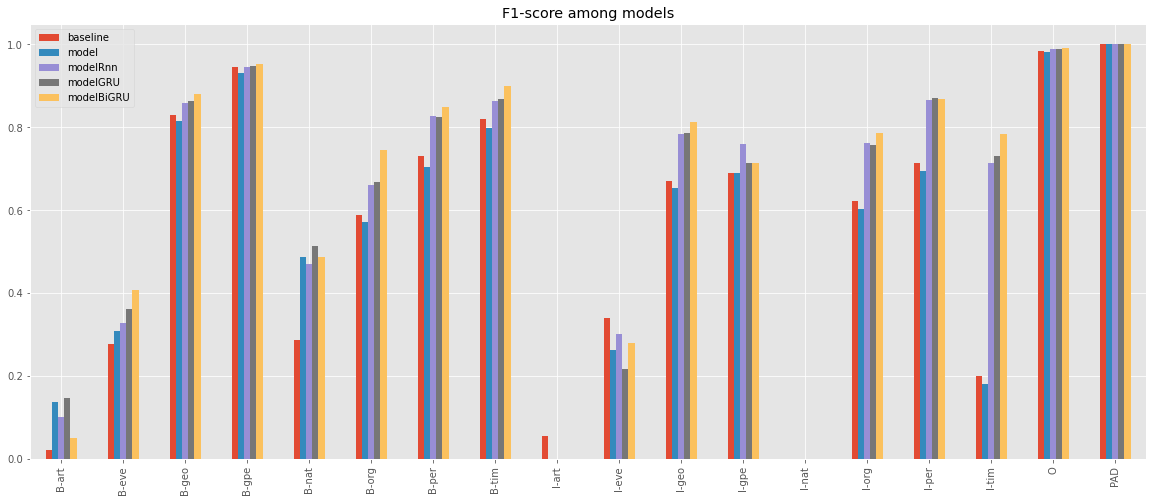

In [0]:
# your code here
f1_df=pd.DataFrame(np.transpose(f1_array), columns=model_name_list, index=tag2idx.keys())
f1_df.plot(kind="bar", figsize=(20,8), title = "F1-score among models")

**3.3** Briefly discuss the performance of each model

*your answer here*

The F1 score is the harmonic average of the precision and recall. A good F1 score means that you have low false positives and low false negatives, so you’re correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it’s 1, while the model is a total failure when it’s 0.

In the above plot, Baseline model has performance similar to FFNN model, while RNN\GRU\BiGRU have similar F1 score distribution. Among the models, Bi-directional GRU gives best performance, because it has significant advantage in terms of B-eve, B-geo, B-org, B-per, B-tim, I-tim. For the I-art where almost no other model gets it right, it still achieved comparable performance with baseline model.



**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

In [0]:
accu_df.mean(axis=1)

B-art    0.161111
B-eve    0.210526
B-geo    0.842611
B-gpe    0.915204
B-nat    0.382609
B-org    0.499748
B-per    0.636471
B-tim    0.742095
I-art    0.007143
I-eve    0.180645
I-geo    0.562992
I-gpe    0.555556
I-nat    0.000000
I-org    0.527901
I-per    0.682472
I-tim    0.107903
O        0.993050
PAD      1.000000
dtype: float64

*your answer here*

Here we choose B-art and I-art as the most wrong index




**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

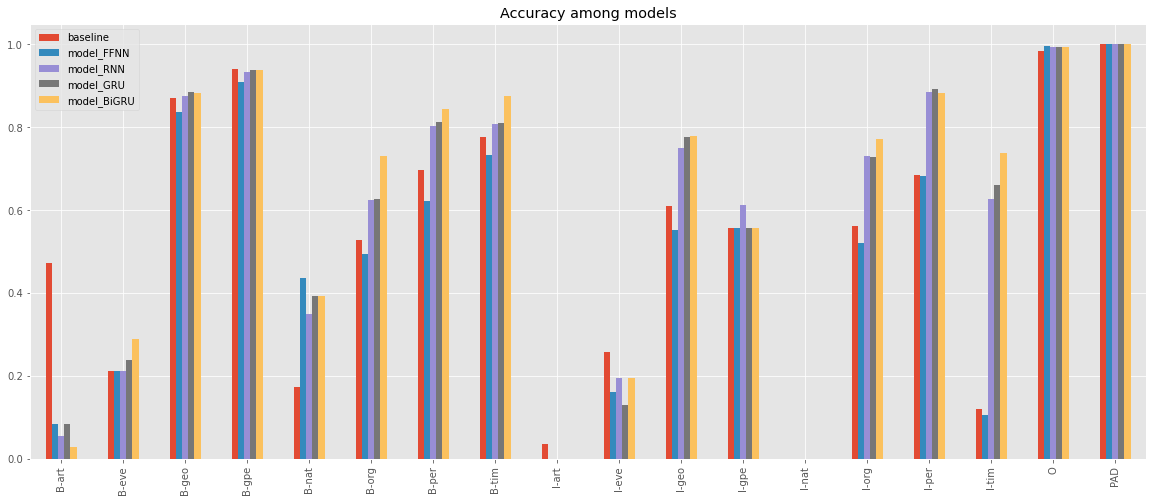

In [0]:
accu_array = np.asarray(accu_list)
accu_df=pd.DataFrame(np.transpose(accu_array), columns=model_name_list[1:], index=tag2idx.keys())
accu_df.plot(kind="bar", figsize=(20,8),title = "Accuracy among models")

In terms of accuracy, baseline model seems better than in terms of F1-score, maybe it is due to the fact that accuracy is better captured by the maximum vote mechanism that baseline model originates. However bidirectional GRU still performs superior because it predicts significantly well with B-eve, B-org, B-tim, I-art, I-tim. Although somtimes simple RNN beats BiGRU, the difference is not as much. Intuitively its bidirectional nature is nore natural to language itself.

However there is something to note here. The PCA plot for BiGRU is quite messy without distinct clustering, but the simple RNN gives rather clean separation. Here I suspect PCA plot cannot capture the nonlinearity among categories, we may just happen to be in the plane where the projection is not as good. However we need more information to support that claim.


In [0]:
most_wrong = ["B-art","I-art"]
most_wrong_index = [tag2idx[i] for i in most_wrong]
ytest_arr = y_test_reshape.reshape((1,4796, 104))

# search for relevant sentences:
sentence_index = []
for tag_id in most_wrong_index:
    ids = np.nonzero(np.logical_and(np.repeat(ytest_arr,5,0)==tag_id, ypred_arr!=tag_id))[1].tolist()
    sentence_index.append(set(ids))
selected_sen = sentence_index[0] & sentence_index[1]
print("sentences that predicts both tags wrong: \n",selected_sen)

sentences that predicts both tags wrong: 
 {930, 4516, 2472, 4328, 3562, 4456, 3662, 4592, 3921, 4305, 3763, 4757, 663, 1850, 2909}


In [0]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [0]:
def giveDF(sid):
    ypred_concat = np.concatenate((ytest_arr, ypred_arr), axis=0)
    temparr =np.moveaxis(ypred_concat,0,2)[sid]
    return(temparr[temparr[:,0] !=tag2idx["PAD"]])

# let us see the second sentence
df=giveDF(list(selected_sen)[1])
# build the dataframe without padding
model_name_list = ['baseline','model_FFNN','model_RNN','model_GRU','model_BiGRU']
model_name_list.insert(0,"y_true")
my_df =pd.DataFrame(np.vectorize(idx2tag.get)(df), columns=model_name_list)

In [0]:
my_df.style.apply(highlight_errors, axis=1)

,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,B-per,I-per,I-per,B-per,B-per,B-per
1,I-per,I-per,I-per,I-per,I-per,I-per
2,O,O,O,O,O,O
3,O,O,O,O,O,O
4,O,O,O,O,O,O
5,O,O,O,O,O,O
6,O,O,O,O,O,O
7,O,O,O,O,O,O
8,O,O,O,O,O,O
9,O,O,O,O,O,O


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)


Here we choose bidirectional GRU as the model to further improve.

The best model from previous attempts is the bidirectional GRU.

We consider several approaches to resolve this issue.

Since the data has very imbalanced tag, we consider to emphasize the minority tags. To achieve this, we either retrain the last few layer of the model by the short sentences, or we can cutomize a loss fuction that better account for such imbalance.

Meanwhile we can consider incorporating convolutional neural network into new model. We can also do batchnormalization, dropout, and random search for best hyperparameter combination.

In [0]:
# your code here
drop_rate = .1
dim_embed = 50
batch_size = 32
validation_split = 0.1
verbose = 1

modelBiGRUNew=Sequential()
modelBiGRUNew.add(Embedding(input_dim=n_words, output_dim=25, input_length=max_len))
modelBiGRUNew.add(Conv1D(filters=25, kernel_size=3, padding='same', activation='relu'))
modelBiGRUNew.add(BatchNormalization())
modelBiGRUNew.add(Dropout(0.05))
modelBiGRUNew.add(Bidirectional(GRU(dim_embed, return_sequences=True)))
modelBiGRUNew.add(TimeDistributed(Dense(n_tags, activation="softmax")))
modelBiGRUNew.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
historyBiGRU = modelBiGRUNew.fit(X_train, y_train, epochs=5,validation_split=validation_split, verbose=verbose)

Epoch 1/5
1214/1214 [==============================] - 135s 111ms/step - loss: 0.0782 - accuracy: 0.9855 - val_loss: 0.0251 - val_accuracy: 0.9926
Epoch 2/5
1214/1214 [==============================] - 132s 109ms/step - loss: 0.0192 - accuracy: 0.9942 - val_loss: 0.0225 - val_accuracy: 0.9932
Epoch 3/5
1214/1214 [==============================] - 135s 111ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0229 - val_accuracy: 0.9933
Epoch 4/5
1214/1214 [==============================] - 136s 112ms/step - loss: 0.0119 - accuracy: 0.9962 - val_loss: 0.0234 - val_accuracy: 0.9933
Epoch 5/5
1214/1214 [==============================] - 134s 111ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.0246 - val_accuracy: 0.9934


In [0]:
model_predict = modelBiGRUNew.predict(x_test)
y_pred = np.argmax(model_predict.reshape((-1,18)), axis=1)
f1_result = f1_score(y_test_reshape,y_pred, average=None)
f1_result

array([0.18181818, 0.5       , 0.87773259, 0.95052001, 0.58823529,
       0.74362975, 0.81791222, 0.89453314, 0.        , 0.34782609,
       0.79894529, 0.77419355, 0.4       , 0.78277635, 0.85638767,
       0.78382838, 0.9908695 , 0.99999238])

There is 7 tages pass 0.8 threshold


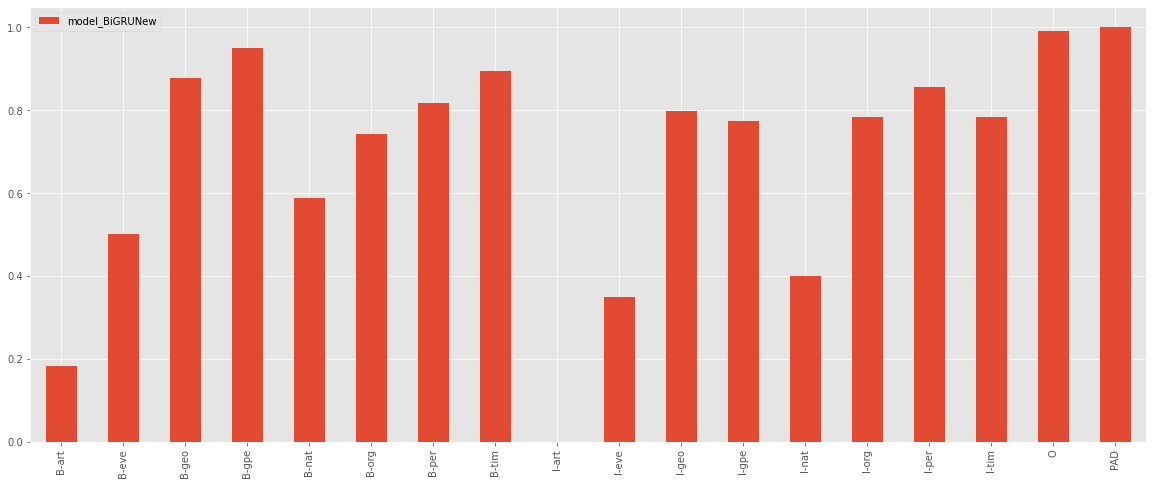

In [0]:
print("There is {} tages pass 0.8 threshold".format(np.sum(f1_result > 0.8)))
f1_df=pd.DataFrame(np.transpose(f1_result), columns=['model_BiGRUNew'], index=tag2idx.keys())
f1_df.plot(kind="bar", figsize=(20,8))

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*

The first model we tries is similar to the previous model with additional conv1d and batchnormalization layers. Under this model, about 7 tags pass 0.8 F1 threshold. CNN bilds feature maps of local word combinations, and batch-normalization helps better convergence.